In [26]:
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import sklearn.datasets
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 10.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'




In [27]:
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=1000, noise=.07)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=200, noise=.07)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

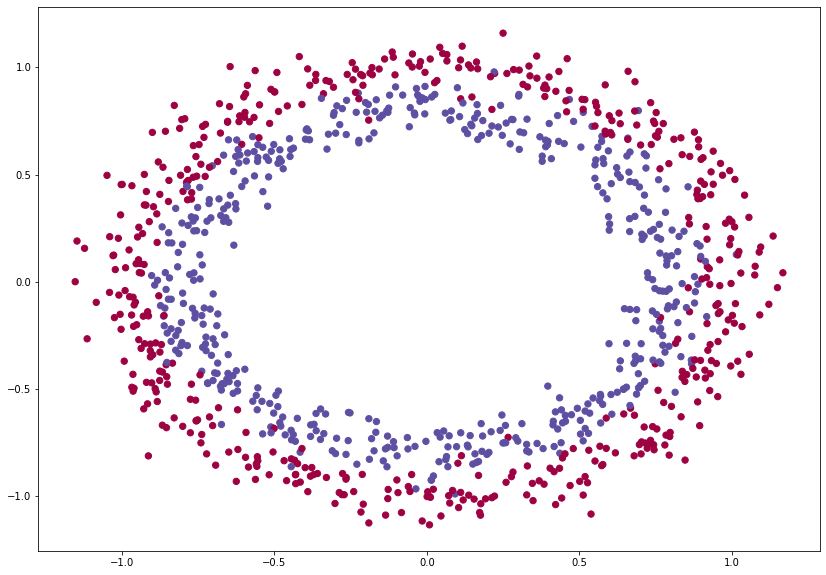

In [28]:
# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

In [30]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((2, 1000), (1, 1000), (2, 200), (1, 200))

In [31]:
# вспомогательные функции
def relu(X):
    return np.maximum(0, X)

def relu_der(X):
    return np.maximum(0, X) / X

def sigmoid(X):
    Y = 1./ (1 + np.exp(-X))
    return Y

def sigmoid_der(X):
    Y = sigmoid(X) * (1 - sigmoid(X))
    return Y

def loss(a, y):
    # loss - бинарная кроссэнтропия 
    return -(y*np.log(a) + (1-y)*np.log(1-a))

def L(a, y):
    # cost function - ее оптимизируем
    #print('a = \n', a, "\n")
    #print('y = \n', y, "\n")
    return -(1./y.shape[1]) * np.sum(loss(a, y))

class NeuralNetwork():
    
    def __init__(self, shapes, activations, init_type='rand', debug=False):
        # shapes - список числа нейронов в слоях кроме последнего, 1-й - размерность входа
        self.shapes = shapes
        self.layers = len(shapes) -1
        self.activations = activations
        self.debug = debug
        self.losses_train = []
        self.acc_test = []
        self.acc_train = []
        self.init_type = init_type
        self._init_params()
    
    def _init_params(self):
        self.W = []
        self.b = []
        if self.init_type == 'rand':
            for i in range(1, len(self.shapes)):
                self.W.append(np.random.randn(self.shapes[i], self.shapes[i-1]) *0.01)
                self.b.append(np.zeros((self.shapes[i], 1)))
        if self.init_type == 'xavier':
            for i in range(1, len(self.shapes)):
                self.W.append(np.random.randn(self.shapes[i], self.shapes[i-1]) * (1/self.shapes[i-1]) **0.5 )
                self.b.append(np.zeros((self.shapes[i], 1)))
                
        if self.debug:
            print('--- Матрицы параметров ---')        
            for W, b in zip(self.W, self.b):
                print(W.shape, b.shape)
            print('--------------------------')        
            
    def normalize_input(self, X, train=True):
        if train:
            self.mu = np.mean(X)
            self.sigma = np.var(X)
        return (X - self.mu) / self.sigma**2
        
        
    def _forward_pass(self, X):
        # делаем без батчей - сразу весь кусок что есть, надеюсь не подавимся
        A = X
        cache = [(X, X)] # она понадобится чтобы посчитать градиент по ней для первого слоя
        for W, b, activation in list(zip(self.W, self.b, self.activations)):
            Z = np.dot(W, A) + b
            A = activation(Z)
            cache.append((A,Z)) 
        return A, cache
            
    def _backward_pass(self, cache, dL):
        # chache содержит все активации по всем слоям, dA - это производная 
        dW_arr = []
        db_arr = []

        dA = dL
        m = dA.shape[1]

        # они идут от 1-го слоя к последнему, а нам надо наоборот
        for i in range(self.layers):
            if self.debug:
                print(self.layers - i - 1)
                
            # смотрим что в этом слое активация и какая у нее производная
            if self.activations[self.layers - i - 1] == sigmoid:
                actitation_der = sigmoid_der
            if self.activations[self.layers - i - 1] == relu:
                actitation_der = relu_der

            Z = cache[self.layers - i][1]                
            dZ = actitation_der(Z) * dA
            if self.debug:
                print('dZ.shape=',dZ.shape)
            
            db = np.expand_dims((1./m) * np.sum(dZ, axis=1), axis=0).T
            db_arr.append(db)
            if self.debug:            
                print('db.shape=',db.shape)
                
            dW = (1./m) * np.dot(dZ, cache[self.layers-i-1][0].T) 
            dW_arr.append(dW)
            if self.debug:            
                print('W.[self.layers - ',i-1,']', self.W[self.layers - i -1].T.shape)
                print('dW.shape=',dW.shape, 'cache[self.layers-',i,'-1][0].T',cache[self.layers-i-1][0].shape)

            dA = np.dot(self.W[self.layers-i-1].T, dZ) 
            if self.debug:
                print('dA.shape=', dA.shape)
        
        dW_arr.reverse()
        db_arr.reverse()
        
        return (dW_arr, db_arr)
        
    def _update_params(self, grads, lr):
        # градиенты [(W1, b1), ... , (Wn, bn)]
        
        for i in range(len(self.W)):
            if self.debug:
                print('layer: ', i, ' norm W:', np.linalg.norm(self.W[i]), ' norm b:', 
                      np.linalg.norm(self.b[i]))
                
            self.W[i] = self.W[i] - lr * grads[0][i]
            self.b[i] = self.b[i] - lr * grads[1][i]
            
    def fit(self, X, y, X_test, y_test, epocs=3000, lr=0.01, batch_size=50):

        X = self.normalize_input(X, train=True).T
        
        if self.debug:
            print('--- входы ---------------------')
            print('X.shape=' , X.shape, 'y.shape=' , y.shape)   
        
        add_tail = 0 if X.shape[1] % batch_size == 0 else 1
        
        for i in range(epocs):
            for j in range(0, X.shape[1] // batch_size + add_tail):
                if self.debug:
                    print(batch_size*j , ":",  min(X.shape[1], batch_size*(j+1)))
               
                X_batch = X[:, batch_size*j : min(X.shape[1], batch_size*(j+1))]
                y_batch = y[:, batch_size*j : min(X.shape[1], batch_size*(j+1))]
                
                A, Cache = self._forward_pass(X_batch)
                
                dL = - (np.divide(y_batch, A) - np.divide(1 - y_batch, 1 - A))
                grads = self._backward_pass(Cache, dL)
                
                if self.debug:
                    dW, db = grads
                    print('-------------- grads ------------------')
                    for dW_, db_ in zip(dW,db):
                        print('dW:', dW_.shape, ' db:', db_.shape)
                    print('---------------------------------------')

                self._update_params(grads, lr)

            # лосс считаем по эпохам
            predict_train = self.predict(X, normalize = False)
            l = L(predict_train, y)
            self.losses_train.append(-l)

            predict_train = np.round(self.predict(X, normalize = False))
            acc_train = accuracy_score(np.squeeze(y), np.squeeze(predict_train))
                
            self.acc_train.append(acc_train)
            y_hat = np.round(self.predict(X_test.T)) 
            acc_test = accuracy_score(np.squeeze(y_test), np.squeeze(y_hat))
            self.acc_test.append(acc_test)                
            
            
            if i % 300 == 0:
                
                print(" ---------------- epoch: ", i+1, ' -----------------------')
                print(" loss: ", l)
            
                # проверяем точность на тесте и точность на трейне

                print(" loss: ", l, ' acc_train:', acc_train, ' acc_test:', acc_test)

    
    def predict(self, X, normalize = True):
        if normalize:
            X = self.normalize_input(X, train=False)
        A, _ = self._forward_pass(X)
        return A


In [32]:
NN = NeuralNetwork([2, 20, 10, 1], activations=[relu, relu, sigmoid], init_type = 'rand')
NN.fit(train_X.T, train_Y, test_X.T, test_Y)

 ---------------- epoch:  1  -----------------------
 loss:  -0.6931495715379431
 loss:  -0.6931495715379431  acc_train: 0.489  acc_test: 0.49
 ---------------- epoch:  301  -----------------------
 loss:  -0.6931442301375581
 loss:  -0.6931442301375581  acc_train: 0.5  acc_test: 0.5
 ---------------- epoch:  601  -----------------------
 loss:  -0.6931383852399328
 loss:  -0.6931383852399328  acc_train: 0.509  acc_test: 0.51
 ---------------- epoch:  901  -----------------------
 loss:  -0.6931230463279848
 loss:  -0.6931230463279848  acc_train: 0.533  acc_test: 0.53
 ---------------- epoch:  1201  -----------------------
 loss:  -0.693061642912609
 loss:  -0.693061642912609  acc_train: 0.536  acc_test: 0.525
 ---------------- epoch:  1501  -----------------------
 loss:  -0.692565640114266
 loss:  -0.692565640114266  acc_train: 0.573  acc_test: 0.565
 ---------------- epoch:  1801  -----------------------
 loss:  -0.6570291144958897
 loss:  -0.6570291144958897  acc_train: 0.769  acc_

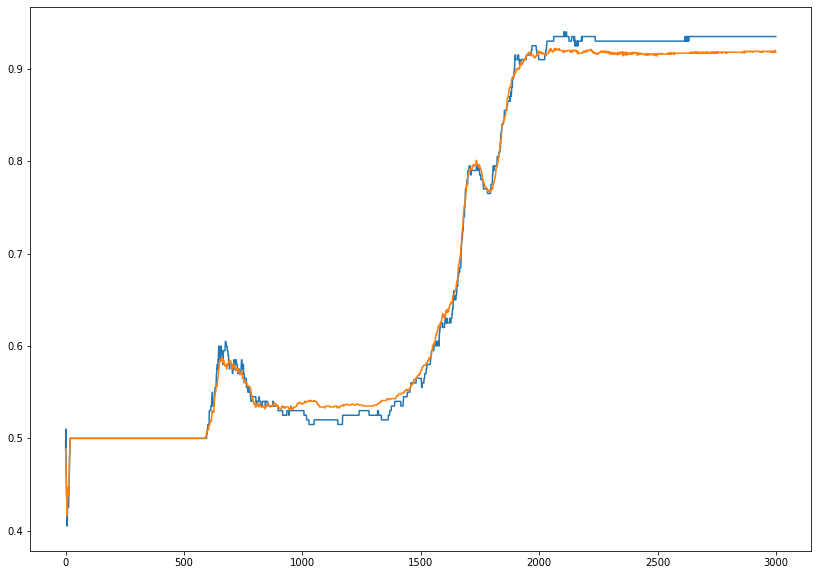

In [33]:
plt.plot(NN.acc_test)
plt.plot(NN.acc_train)
plt.show()

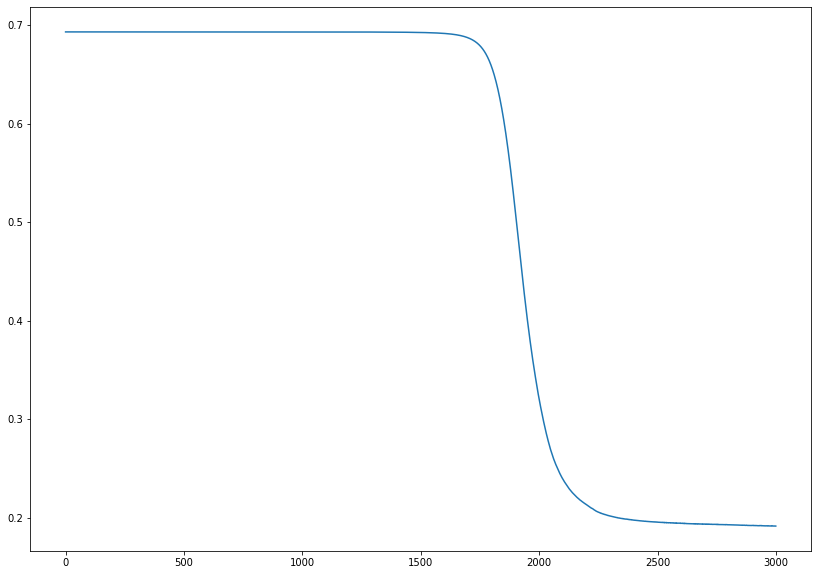

In [34]:
plt.plot(NN.losses_train)

In [35]:
y_hat = NN.predict(test_X) 
y_hat = np.round(y_hat.reshape(y_hat.shape[1],))

print(y_hat.shape, test_Y.shape )
accuracy_score(test_Y.T, y_hat)

(200,) (1, 200)


0.935

In [36]:
NN = NeuralNetwork([2, 20, 10, 1], activations=[relu, relu, sigmoid], init_type = 'xavier')
NN.fit(train_X.T, train_Y, test_X.T, test_Y)

 ---------------- epoch:  1  -----------------------
 loss:  -0.6983350064132184
 loss:  -0.6983350064132184  acc_train: 0.497  acc_test: 0.5
 ---------------- epoch:  301  -----------------------
 loss:  -0.25932560520547704
 loss:  -0.25932560520547704  acc_train: 0.917  acc_test: 0.94
 ---------------- epoch:  601  -----------------------
 loss:  -0.19464684799946919
 loss:  -0.19464684799946919  acc_train: 0.92  acc_test: 0.94
 ---------------- epoch:  901  -----------------------
 loss:  -0.19044134092530488
 loss:  -0.19044134092530488  acc_train: 0.922  acc_test: 0.94
 ---------------- epoch:  1201  -----------------------
 loss:  -0.18866750784937
 loss:  -0.18866750784937  acc_train: 0.925  acc_test: 0.94
 ---------------- epoch:  1501  -----------------------
 loss:  -0.18748381976139974
 loss:  -0.18748381976139974  acc_train: 0.928  acc_test: 0.94
 ---------------- epoch:  1801  -----------------------
 loss:  -0.18636733539929662
 loss:  -0.18636733539929662  acc_train: 0.

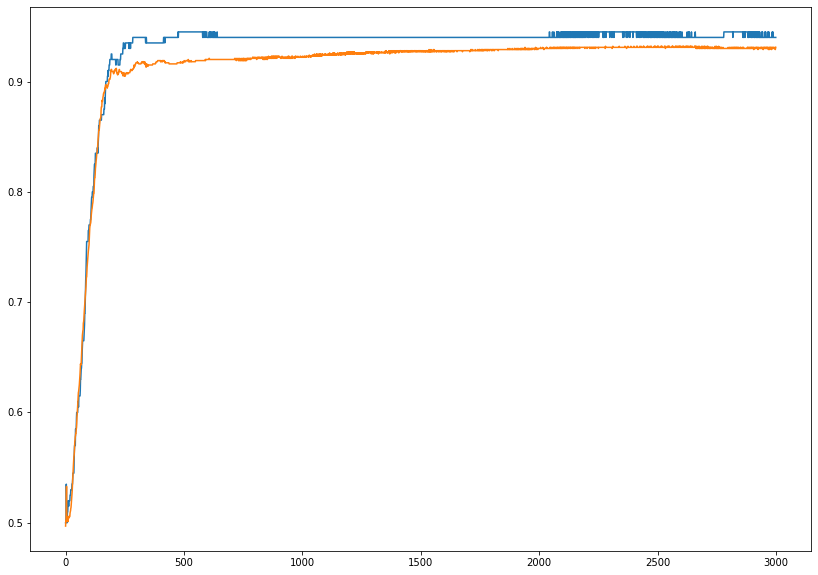

In [37]:
plt.plot(NN.acc_test)
plt.plot(NN.acc_train)
plt.show()

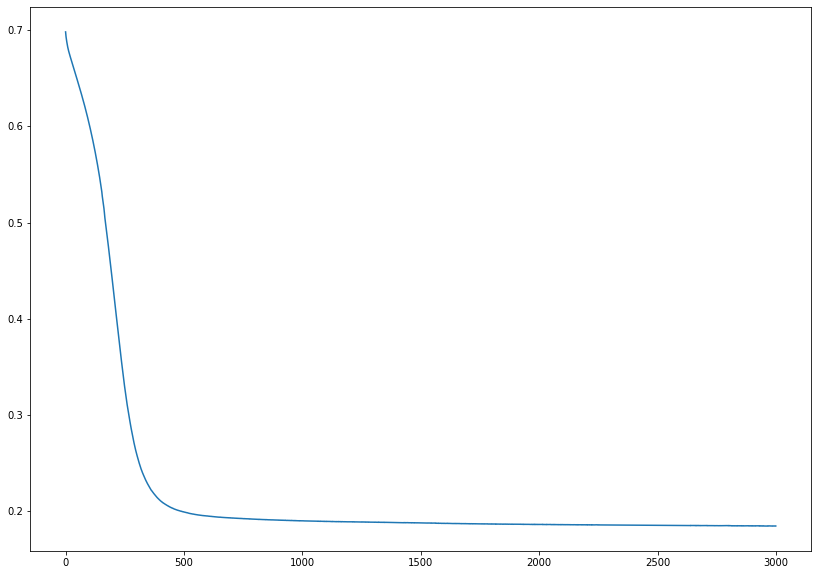

In [38]:
plt.plot(NN.losses_train)